In [29]:
from __future__ import print_function

import pandas as pd
import yfinance as yf
import numpy as np
import datetime
import warnings
from pandas_datareader.data import DataReader

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sns

import pickle

The Background Setup To create the HMM model and plot the model against the spy returns
to see if the model is behaving "correctly" ie. is it defining regime 0 as 'normal' times
and regime 1 as 'volatile' times

In [23]:
#obtain price data
def obtain_prices_df(csv_filepath, end_date):
    #obtain the prices DataFrame from the CSV file, 
    #filter by the end date and calucate the percentage returns
    
    df = pd.read_csv(
    csv_filepath,
    header=0,
    parse_dates=True,
    names= [
        "Date", "Open", "High", "Low", 
        "Close", "Volume", "Adj Close"
    ],
    )
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Date'] = df['Date'].astype('string')
    df = df.set_index('Date')
    df["Returns"] = df["Adj Close"].pct_change()
    df = df[:end_date.strftime("%Y-%m-%d")]
    df = df[:end_date]
    df.dropna(inplace=True)
    return df
#I modified his code to cast the date column as a string. For some reason the strftime kept throwing an error even if I convered
#the column to a datetime. This this is only used for the hidden markov model I don't think this will be a problem.
    

#trying to fix the slice outside of the function
df = pd.read_csv(
    'data/SPY.csv',
    header=0,
    parse_dates=True,
    names= [
        "Date", "Open", "High", "Low", 
        "Close", "Volume", "Adj Close"
    ],
    )
df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].astype('string')
#df = df.set_index('Date')
df["Returns"] = df["Adj Close"].pct_change()
#df = df[:end_date.strftime("%Y-%m-%d")]
df.dropna(inplace=True)
df

#test obtain_prices_df
end_date = '2005-01-01'
obtain_prices_df('data/SPY.csv', end_date)
#NOTE THESE RETURNS ARE NOT LOG RETURNS AND THIS MAY SKEW RESULTS. 

Plot the HMM states

In [24]:
def plot_in_sample_hidden_states(hmm_model, df):
    '''
    Plot the adjusted closing prcies masked by 
    the in-sample hidden states as a mechanism 
    to understand the market regimes.
    '''
    #Predict the hidden states array
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
    hmm_model.n_components,
    sharex=True, sharey=True, figsize=(12,8)
    )
    colors = cm.rainbow(
    np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, color)in enumerate(zip(axs, colors)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask],
            df['Adj Close'][mask],
            ".", linestyle='none',
            c=color
        )
        ax.set_title("Hiddden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
        
    plt.show()


Model Score: 12200.611475360209


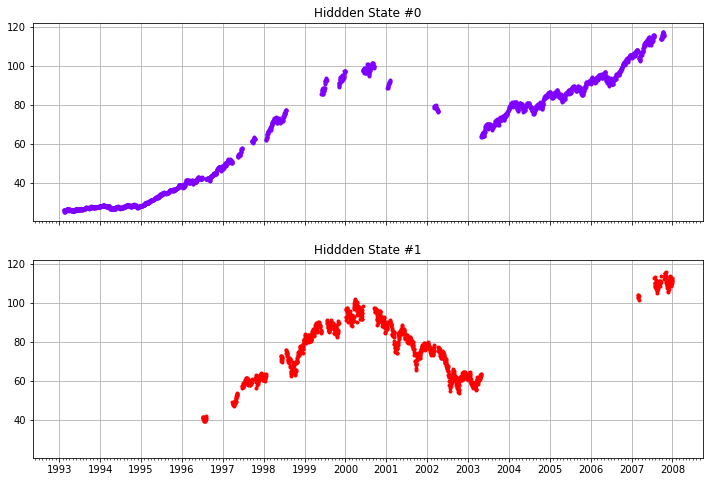

Pickling HMM model...
...HMM model pickled


In [25]:
if __name__=="__main__":
    #Hides deprecation warnings for sklearn
    warnings.filterwarnings("ignore")
    
    #Create the SPY dataframe from the Yahoo Finance CSV
    # and correctly format the returns for use in the HMM
    csv_filepath = "data/SPY.csv"
    pickle_path = "hmm_model_spy.pkl"
    end_date = datetime.datetime(2007, 12, 31)
    
    #this is calling the function above
    spy = obtain_prices_df(csv_filepath, end_date)
    rets = np.column_stack([spy["Returns"]])
    
    #create the Gaussian Hidden markov Model and fit it
    #to the SPY returns, data,df outputting a score
    hmm_model = GaussianHMM(
        n_components=2, 
        covariance_type = "full",
        n_iter=1500
    ).fit(rets)
    print("Model Score:", hmm_model.score(rets))
    
    #Plot the in sample hidden states closing values
    plot_in_sample_hidden_states(hmm_model, spy)
    
    print("Pickling HMM model...")
    pickle.dump(hmm_model, open(pickle_path, "wb"))
    print("...HMM model pickled")

#me trying to work around the fact the function won't run
df = pd.read_csv(
'data/Spy.csv', header=0,
names= [
"Date", "Open", "High", "Low", 
"Close", "Volume", "Adj Close"
],
index_col= "Date", parse_dates=True
)
df["Returns"] = df["Adj Close"].pct_change()
df = df [:end_date.strftime("%Y-%m-%d")]
df.dropna(inplace=True)
#this should plug in the function above, but it isn't working
spy = df
rets = np.column_stack([spy["Returns"]])

#create the Gaussian Hidden markov Model and fit it
#to the SPY returns, data, outputting a score
hmm_model = GaussianHMM(
    n_components=2, 
    covariance_type = "full",
    n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

#Plot the in sample hidden states closing values
plot_in_sample_hidden_states(hmm_model, spy)

print("Pickling HMM model...")
pickle.dump(hmm_model, open(pickle_path, "wb"))
print("...HMM model pickled")

QS Trader Strategy Logic

In [ ]:
# regime_hmm_strategy.py

from __future__ import print_function

from collections import deque

import numpy as np 

from qstrader.price_parser import PriceParser
from qstrader.event import (SignalEvent, EventType)
from qstrader.strategy.bae import AbstractStrategy

class MovingAverageCrossStrategy(AbstractStrategy):
    '''
    Requires:
    tickers - the list of ticker symbols
    events_queue - A handle to the system events queue
    short_window - Lookback period for the short moving average
    long_window - Lookback period for the long moving average
    '''
    def __init__(
        self, tickers,
        events_queue, base_quantity, 
        short_window=10, long_window=30
    ):
        self.tickers = tickers
        self.events_queue = events_queue
        self.base_quantity = base_quantity
        self.short_window - short_window
        self.long_window = long_window
        self.bars = 0
        self.invested = False
        self.sw_bars = deque(maxlen=self.short_window)
        self.lw_bars = deque(maxlen=self.long_window)
        
    def calculate_signals(self, event):
        # Applies SMA to first ticker
        ticker = self.tickers[0]
        if event.type == EventType.BAR and event.ticker == ticker:
            #Add latest adjusted closing price to the
            #short and long window bars
            price = event.adj_close_price / float(
                PriceParser.PRICE_MULTIPLIER
            )
            self.lw_bars.append(price)
        
        # Enough bars are present for trading
        if self.bars > self.long_window:
            #Calculate the simple moving averages
            short_sma = np.mean(self.sw_bars)
            long_sma = np.mean(self.lw_bars)
            # Trading signals based on moving average cross
            if short_sma > long_sma and not self.invested:
                print("LONG: %s" % event.time)
                signal = SignalEvent(ticker, "BOT", self.base_quantity)
                self.events_queue.put(signal)
                self.invested = True
            elif short_sma < long_sma and self.invested:
                print("SHORT": %s" % event.time)
                signal = SignalEvent(ticker, "SLD", self.base_quantity)
                self.events_queue.put(signal)
                self.invest = False
        self.bars += 1
                      

Regime for Risk Manager

In [ ]:
# regime_hmm_risk_manager.py

from __future__ import print_function

import numpy as np 

from qstrader.event import OrderEvent
from qstrader.price_parser import PriceParser
from qstrader.risk_manager.base import AbstractRiskManager


class RegimeHMMRiskManager(AbstractRiskManager):
    """
    Utilises a previously fitted Hidden Markov Model
    as a regime detection mechanism. The risk manager
    ignores orders that occur during a non-desirable regime.
    
    It also acounts for the fact that a trade may straddle two separate regimes.
    If a close order is received in the undesirable regime, and the order is open, 
    it will be closed, but no new orders are generated until the desirable regime
    is achieved
    """
    def __init__(self, hmm_model):
        self.hmm_model = hmm_model
        self.invested = False
    
    def determine_regime(self, price_handler, sized_order):
        """
        Determines the predicted regime by making a prediction
        on the adjusted closing returns from the price handler
        object and then taking the final entry integer
        as the "hidden regime state"
        """
        returns = nmp.column_stack(
            [np.array(price_handler.adj_close_returns)]
        )
        hidden_state = self.hmm_model.predict(returns)[-1]
        return hidden_state
    
    def refine_orders(self, portfolio, sized-order):
        """
        Uses the Hidden Markov Model with the percentage returns
        to predict the current regime, either 0 for desirable or
        1 for undesirable. Long entry trades will only be carried
        out in regime 0, but closing trades are allowed in regime 1.
        """
        # Determine the HMM predicted regime as an integer
        # equal to 0 (desirable) or 1 (undesirable)
        price_handler = portfolio.price_handler
        regime = self.determine_regime(
            price_handler, sized_order
        )
        action = sized_order.ticker
        # Create the order event, irrespective of the regime.
        # It will only be returned if the correct conditions
        # are met below. 
        order_event = OrderEvent(
            sized_order.ticker,
            sized_order.action,
            sized_order.quantity
        )
        #If in the desirable regime, let buy and sell orders
        # work as normal for a long-only trend following strategy
        if regime == 0:
            if action == "BOT":
                self.invested = True
                return [order_event]
            elif action == "SLD":
                if self.invested == True:
                    self.invested = False
                    return [order_event]
                else:
                    return []
        # If in the undesirable regime, do not allow any buy orders
        # and only let sold/close orders through if the strategy 
        # is already invested (from a previous desirable regime)
        elif regime == 1:
            if action == "BOT":
                self.invested = False
                return []
            elif action == "SLD":
                if self.invested == True:
                    self.invested = False
                    return [order_event]
                else:
                    return []

Regime hmm_backtest

In [31]:
import qstrader

In [32]:
# regime_hmm_backtest.py

import datetime
import pickle

import click
import numpy as np

from qstrader import settings
from qstrader.compat import queue
from qstrader.price_parser import PriceParser
from qstrader.price_handler.yahoo_daily_csv_bar import \
    YahooDailyCsvBarPriceHandler
from qstrader.strategy import Strategies, DisplayStrategy
from qstrader.position_sizer.naive import NaivePositionSizer
from qstrader.risk_manager.example import ExampleRiskManager
from qstrader.portfolio_handler import PortfolioHandler
from qstrader.compliance.example import ExampleCompliance
from qstrader.execution_handler.ib_simulated import \
    IBSimulatedExecutionHandler
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading_session.backtest import Backtest

from regime_hmm_strategy import MovingAverageCrossStrategy
from regime_hmm_risk_manager import RegimeHMMRiskManger

#I'm adding these because these worked for the 60/40 backtest

#needed to handle timestamp functionality with timezones
import pytz

#equity tells the model the data from CSV files represent equity prices/volumes
from qstrader.asset.equity import Equity

#static universe tells the model we won't be changing the assets used over time
from qstrader.asset.universe.static import StaticUniverse

#this tells the model how our asset universe specification and data sources are linked
from qstrader.data.backtest_data_handler import BacktestDataHandler

#tells the model our datasource is from CSV files
from qstrader.data.daily_bar_csv import CSVDailyBarDataSource



ModuleNotFoundError: No module named 'qstrader.compat'

In [ ]:
if __name__ == "__main__":
    start_dt = pd.Timestamp('2008-01-1 14:30:00', tz=pytz.UTC)
    end_dt = pd.Timestamp('2022-05-13 23:59:00', tz=pytz.UTC)

In [ ]:
# Construct the symbols and assets necessary for the backtest
strategy_symbols = ['SPY']
strategy_assets = ['EQ:%s' % symbol for symbol in strategy_symbols]
strategy_universe = StaticUniverse(strategy_assets)

In [ ]:
# To avoid loading all CSV files in the directory, set the
# data source to load only those provided symbols
csv_dir = os.environ.get('QSTRADER_CSV_DATA_DIR', '.')
data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=strategy_symbols)
data_handler = BacktestDataHandler(strategy_universe, data_sources=[data_source])

In [ ]:
def run(config, testing, tickers, filename):
    #set up variables needed for backtest
    pickle_path = "hmm_model_spy.pkl"
    events_queue = queue.Queue()
    csv_dir = config.CSV_DATA_DIR
    initial_equity = PriceParser.parse(500000.00)
    
    #Use Yahoo daily Price Handler
    start_date = datetime.datetime(2008, 1, 1)
    end_date = datetime.datetime(2022, 5, 13)
    price_handler = YahooDailyCsvBarPriceHandler(
        csv_dir, events_queue, tickers,
        start_date = start_date, end_date= end_date,
        calc_adj_returns=True
    )
    
    # Use the Moving Average Crossover trading strategy
    base_quantity = 10000
    strategy = MovingAverageCrossStrategy(
        tickers, events_queue, base_quantity,
        short_window=10, long_window=30
    )
    strategy = Strategies(strategy, DisplayStrategy())
    
    #Use the Naive Position Sizer
    # where suggested quantities are followed
    position_sizer = NaivePositionSizer()
    
    #Use the default Portfolio Handler
    portfolio_handler = PortfolioHandler(
        initial_equity, events_queue, price_handler,
        position_sizer, risk_manager
    )
    
    #Use the ExampleCompliance component
    compliance = ExampleCompliance(config)
    
    #Use a simulated IB Execution Handler
    execution_handler = IBSimulatedExecutionHandler(
        events_queue, price_handler, compliance
    )
    
    # Use the Tearsheet Statistics
    title = ["Trend Following Regime Dection with HMM"]
    statistics = TearsheetStatistics(
        config, portfolio_handler, title,
        benchmark="SPY"
    )
    
    # Set up the backtest 
    backtest = Backtest(
        price_handler, strategy,
        portfolio_handler, execution_handler,
        position_sizer, risk_manager, 
        statistics, initial_equity
    )
    results = backtest.simulate_trading(testing=testing)
    statistics.save(filename)
    return results

@click.command()
@click.option(
    '--config',
    default=setings.DEFAULT_CONFIG_FILENAME,
    help='Config filename'
)
@click.option(
    '--testing/--no-testing',
    defualt=False, help='Enable testing mode'
)
@click.option(
    '--tickers', defualt='SPY',
    help='Tickers (use comma)'
)
@click.option(
    '--filename', defualt='',
    help='Pickle (.pkl) statistics filename'
)
def main(config, testing, tickers, filename):
    tickers = tickers.split(",")
    config = settings.from_file(config, testing)
    run(config, testing, tickers, filename)

if __name__ == "__main__":
    main()